<a href="https://colab.research.google.com/github/sdam-au/modelling_temporal_uncertainty/blob/master/scripts/TEMPORAL-DISTRIBUTIONS_minimal-examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [2]:
from scipy.stats import trapz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

!pip install sddk
import sddk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

# Modelling ranges

## Trapezoidal distribution


As a minimal example, let's assume that we have datation "4th c. BC".
As a first step, we have to operationalize its start and stop points:

In [3]:
start = -400
stop = -301

 Further,  I assume that the the probability that the object emerged in 385 BC, 350 BC or 320 BC is **approximately equal** . 
At the same time, it is **less likely** that the  object emerged in the first or last decade of the century, since this would be probably coded in another way (e.g. "beginning of the 4th c. BC" etc.).

It seems that the best way how to model this is through a [trapezoidal distrubution](https://en.wikipedia.org/wiki/Trapezoidal_distribution).

In Python, trapezoidal distribution is implemented in SciPy library as [scipy.stats.trapz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trapz.html). 


We will use this function as a core for our function optimized for working with date ranges

In [4]:
def dist_range(start, stop, size=1, b=0.1): # this function has been implemented into already modelling_distributions.py
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  r = trapz.rvs(b, 1-b, size=size)
  duration = abs((start)-stop)
  if duration == 0:
    random_values = [start] * size
    return random_values
  else:
    random_values = list(((r * duration) + start).round().astype(int))
    if size == 1: # if only one number, return it as a number
      return random_values[0]
    else: # otherwise return a list of values
      return random_values

In [5]:
start = -20
stop = -18
print(dist_range(start, stop, 30))

[-19, -20, -19, -19, -19, -19, -19, -18, -19, -20, -18, -18, -18, -18, -19, -20, -20, -19, -19, -18, -19, -19, -19, -18, -19, -19, -19, -18, -20, -20]


If we specify only start and end, it returns only one random number within the range. By default, the two bending points are configured to 0.1 and 0.9  of the duration of the function.

In [6]:
# 1 random numbers within the range defined by start and stop
# if we want more numbers, we can add a third argument specifying "size", i.e. how many numbers we want
# by default, it follows trapezoidal distribution, with lineary decreasing probability for the first 10% and the last 10% years wihin the range
# that means that any numbers after the first 10% and before the last 10% has equal probability to be returned
dist_range(start, stop)

-18

This way we can produce a large amount of numbers for each date range in our dataset

In [16]:
raw_date = "4th c. BC"
start = -400
stop = -301
n_of_iterations = 100000
iters = dist_range(start, stop, n_of_iterations)

For one date range, the resulting distrubution might be visualized by means of a histogram:

(-400.0, -301.0)

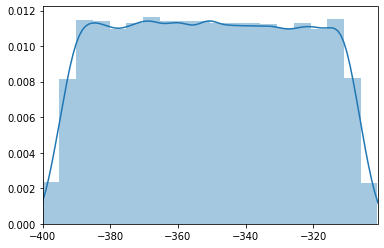

In [18]:
sns.distplot(iters, bins=20)
plt.xlim(start, stop)

# Modelling ante quem & post quem

A very common way of dating in our dataset is using **ante quem** (before that date) and **post quem** (after that date).

Again, here we have to ask about the shape of the distribution we want to model.

## a) Trapezoidal
One option is to approach it the same way as ranges, as a combination of uniform and triangular distribution. We can use our code for trapezoidal distrubution and just set up *a* = *b*, i.e. that the lower bound equals to the first bending point.  

In [8]:
def dist_ante_post(date, date_type, size=1, duration=100):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  if "post" in date_type:
    r = trapz.rvs(0, 0.50, size=size)
    return ((r * duration) + date).astype(int)
  if "ante" in date_type:
    r = trapz.rvs(0.50, 1, size=size)
    return ((r * duration) + date).astype(int)

Test with "post 250 AD"

In [10]:
dist_ante_post(250, "post")

array([256])

In [11]:
iters = dist_ante_post(250, "post", 5000)

(250.0, 350.0)

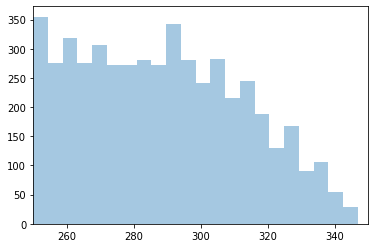

In [12]:
sns.distplot(iters, kde=False) # alternatively: hist=False
plt.xlim(250, 350)

## b) Half-normal distribution

Perhaps a better model would be a normal distribution with rather long tail



In [55]:
from scipy.stats import halfnorm

Here we can especially play with the `scale` parameter.



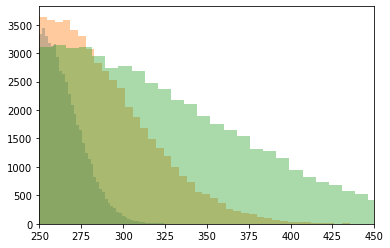

In [14]:
for scale in [20, 50, 100]:
  r = halfnorm.rvs(250, scale, 50000)
  sns.distplot(r, kde=False)
  plt.xlim(250, 450)

`scale`=50 appears to be very useful for applications where centuries are common, like PHI or EDH. So let's implement it to our model as default value.

In [53]:
def dist_ante_post(date, date_type, size=1, scale=50): # this function has been implemented into already modelling_distributions.py
  """
  get random numbers of size size ib on the basis of start date and end date and half-normal distribution defined by first turn point (lower bound)
  start & stop are treated as not before and not after, i.e. as included
  """
  if "post" in date_type:
    r = np.round(halfnorm.rvs(scale=scale, size=size)).astype(int)
    random_values = list((date - 1) + r)
  if "ante" in date_type:
    r = np.round(halfnorm.rvs(scale=scale, size=size)).astype(int)
    random_values =  list((date + 1) - r)
  if size == 1:
    return random_values[0]
  else:
    return random_values

In [56]:
dist_ante_post(100, "post", size=10, scale=10)

[104, 99, 110, 100, 119, 99, 105, 103, 107, 99]

In [138]:
# simple test with "post"
dist_ante_post(250, "post", size=10, scale=5)

[252, 251, 257, 250, 257, 250, 250, 253, 258, 255]

In [131]:
# simple test with "ante"
dist_ante_post(250, "ante", 10, 50)

[192, 214, 232, 227, 244, 225, 182, 227, 154, 220]

What exactly does the scale parameter?

In [57]:
results = []
scale = int(input("scale: "))
for n in range(1000):
  r = np.array(dist_ante_post(0, "post", 10000, scale))
  results.append(len(r[r < scale]) / 10000)
print(results)
print(np.mean(results))

scale: 50
[0.6835, 0.6836, 0.6848, 0.6892, 0.6873, 0.6877, 0.6911, 0.687, 0.685, 0.6816, 0.691, 0.6922, 0.6853, 0.683, 0.6937, 0.6867, 0.701, 0.6876, 0.6881, 0.6908, 0.6826, 0.6863, 0.6846, 0.6873, 0.6953, 0.6841, 0.6841, 0.6807, 0.6838, 0.6859, 0.69, 0.6872, 0.693, 0.6873, 0.6923, 0.6899, 0.6877, 0.6905, 0.6895, 0.6928, 0.6778, 0.6831, 0.6794, 0.686, 0.6832, 0.6897, 0.6955, 0.6828, 0.6848, 0.6789, 0.6899, 0.6792, 0.6838, 0.693, 0.6796, 0.6871, 0.6894, 0.6944, 0.6948, 0.6863, 0.6811, 0.687, 0.6822, 0.6875, 0.6844, 0.6827, 0.6884, 0.6881, 0.6926, 0.6804, 0.687, 0.6852, 0.6845, 0.6906, 0.6878, 0.6914, 0.6886, 0.6789, 0.6854, 0.7002, 0.6935, 0.6936, 0.6868, 0.6899, 0.6948, 0.6984, 0.6883, 0.6861, 0.69, 0.6896, 0.6866, 0.6833, 0.693, 0.6874, 0.6867, 0.6781, 0.6865, 0.6884, 0.6937, 0.6951, 0.6871, 0.6957, 0.6895, 0.6915, 0.6861, 0.6879, 0.6833, 0.6896, 0.6797, 0.6799, 0.6842, 0.6804, 0.682, 0.6905, 0.6906, 0.6799, 0.6833, 0.6879, 0.6876, 0.6833, 0.6884, 0.693, 0.6921, 0.6884, 0.6853, 0.6878

In [ ]:
np.mean(results)

0.2891567

# function "model_date()"

In [21]:
def model_date(start, stop, size=1, scale=50, b=0.1):
    """
    combine dist_range() and dist_ante_post()
    """
    try:
      randoms = dist_range(int(start), int(stop), size=size, b=b)
    except:
      try:
        randoms =  dist_ante_post(int(start), "post", size=size, scale=scale)
      except:
        try:
          randoms =  dist_ante_post(int(stop), "ante", size=size, scale=scale)
        except:
          randoms = None
    return randoms


In [151]:
# example: 
# both dates valid
start = -400 - 1
stop = -390
print(model_date(start, stop, size=20, b=0))

[-392, -399, -393, -398, -397, -395, -395, -391, -400, -394, -393, -401, -392, -400, -399, -396, -399, -394, -394, -395]


In [152]:
# example: 
# both dates valid
# modified bounding_box_b to uniform distr
start = -400
stop = None
print(model_date(start, stop, size=20))

[-295, -375, -394, -385, -365, -328, -377, -283, -341, -370, -366, -355, -312, -381, -360, -332, -383, -358, -380, -381]


In [52]:
# example: 
# invalid start interpreted as ante stop
start = "something nonnumerical"
stop = 72
print(model_date(start, stop, size=20))

None


# Distribution shapes overview

Text(0.5, 1.0, '(d) Half-normal distribution')

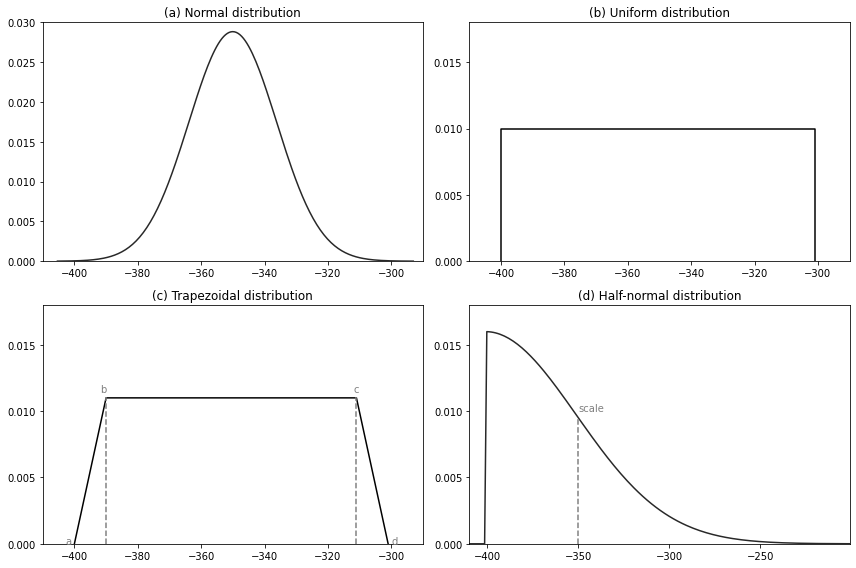

In [185]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

# NORMAL DISTRIBUTION
r = norm.rvs(-350, 14, 10000)
sns.distplot(r, fit=norm, hist=False, kde=False, ax=ax0)
ax0.set_xlim(-410, -290)
ax0.set_ylim(0, 0.03)
ax0.set_title("(a) Normal distribution")


# UNIFORM DISTRIBUTION
ax1.plot([-400, -400, -301, -301], [0, 0.01, 0.01, 0], color="black")
ax1.set_xlim(-410, -290)
ax1.set_ylim(0, 0.018)
ax1.set_yticks([0, 0.005, 0.01, 0.015])
ax1.set_title("(b) Uniform distribution")

# TRAPEZOIDAL DISTRIBUTION
ax2.plot([-400, -390, -311, -301], [0, 0.011, 0.011, 0], color="black")
ax2.set_xlim(-410, -290)
ax2.set_ylim(0, 0.018)
ax2.set_yticks([0, 0.005, 0.01, 0.015])
ax2.axvline(-390, 0, 0.615,linestyle="--", color="grey")
ax2.axvline(-311, 0, 0.615,linestyle="--", color="grey")
ax2.text(-403, 0, "a", color="grey") 
ax2.text(-392, 0.0114, "b", color="grey") 
ax2.text(-312, 0.0114, "c", color="grey") 
ax2.text(-300, 0, "d", color="grey") 


ax2.set_title("(c) Trapezoidal distribution")

# HALFNORMAL DISTRIBUTION
r = model_date(-400, "", 100000)
sns.distplot(r, fit=halfnorm, hist=False, kde=False, ax=ax3)
ax3.set_xlim(-410, -201)
ax3.set_ylim(0, 0.018)
ax3.set_yticks([0, 0.005, 0.01, 0.015])
ax3.set_xticks([-400, -350, -300, -250])
ax3.axvline(-350, 0, 0.53,linestyle="--", color="grey")
ax3.text(-350, 0.01, "scale", color="grey") #, transform=trans)
ax3.set_title("(d) Half-normal distribution")


In [181]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [186]:
#public_folder_link = "69932bf8fbdd2b37a23e1e5ae1c3206b"
sddk.write_file("SDAM_data/temporal_uncertainty/distributions_overview.png", fig, conf)

A file with the same name ("distributions_overview.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/temporal_uncertainty/distributions_overview.png"


In [184]:
# the figure has been uploaded into a public figure
# and might be accessed via this link
# (the number is id of the public folder)
# "https://sciencedata.dk/public/69932bf8fbdd2b37a23e1e5ae1c3206b/distributions_overview.png"

# Test with some dataset

Now let's define two crucial functions:
The first produces a new column in our dataframe, which contain random numbers within a range of specified start and stop date columns, following the trapezoidal distribution.

The second function then approach this column and extract values from it

## a) Test with mounds

In [ ]:
AOR_df = sddk.read_file("SDAM_data/mounds/AOR_df.json", "df", conf)
Izvestia_df = sddk.read_file("SDAM_data/mounds/Izvestia_df.json", "df", conf)

In [ ]:
AOR_df.head(5)

,MoundID,Municipality,Region,Lat,Long,Error radius(m),LU_Around,MoundCover,Geomorphology,Prominence,MoundName,HeightMax,HeightMin,DiameterMax,DiameterMin,GT,RT,Condition,Source of Impact,NumberOfBurialsInside,FirstStartDate,FirstEndDate,MaxEndDate,FirstChronologyRating,FirstEnclosureType,Graves,FirstBurialNumber,GraveRankSymbols,AllDates,TotalBurialNumber,BurialAttributesAggr
0,1107,Sliven,Sliven,42.491623,26.269778,0,Annual agriculture,No data,hillside,"somewhat prominent (on a plateau, slope or spu...",no name,5.6,1.6,36,34,,Y,2 - partially damaged (type of damage is descr...,looting,10,0.0,100.0,400.0,2 - specialist consulted on a single item,,10,1,"[0, 1]","[[0.0, 100.0], [0.0, 100.0], [0.0, 100.0], [0....",10.0,"{'0': {'index': 743, 'MoundID': 1107, 'Name': ..."
1,1179,Belitsa,Blagoevgrad,41.935714,23.573565,0,Pasture (grassland),Pasture (grassland),on the ridge,very (on an outcrop or peak),Mogilata sas sarkofaga,7,,30,,,N,"1 - pristine, (only superficial or minor damag...",,1,-400.0,-300.0,-300.0,2 - specialist consulted on a single item,Cist grave,1,1,[2],"[[-400.0, -300.0]]",1.0,"{'0': {'index': 1190, 'MoundID': 1179, 'Name':..."
2,1392,Belitsa,Blagoevgrad,41.919751,23.572341,0,No data,No data,on the ridge,"somewhat prominent (on a plateau, slope or spu...",Golyamata mogila,4,,30,25,,N,"1 - pristine, (only superficial or minor damag...",,1,NaN,NaN,NaN,0 - no chronology,Simple pit,1,1,[0],"[[None, None]]",1.0,"{'0': {'index': 1992, 'MoundID': 1392, 'Name':..."
3,1393,Blagoevgrad,Blagoevgrad,41.976922,23.093051,100,Scrub,No data,hilltop,very (on an outcrop or peak),Kaymenska chuka,,,,,,Y,2 - partially damaged (type of damage is descr...,looting,4,200.0,300.0,300.0,1 - rough estimate by author on basis of the a...,Tiled grave,4,1,[0],"[[200.0, 300.0], [200.0, 300.0], [200.0, 300.0...",4.0,"{'0': {'index': 1993, 'MoundID': 1393, 'Name':..."
4,1012,Primorsko,Burgas,42.277825,27.726949,200,Forest,Forest,"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",Chenger 1,3.25,2.98,28.6,26.8,,N,"1 - pristine, (only superficial or minor damag...",,2,-400.0,-200.0,-200.0,1 - rough estimate by author on basis of the a...,Simple pit,2,1,"[2, 1]","[[-400.0, -200.0], [None, None]]",2.0,"{'0': {'index': 120, 'MoundID': 1012, 'Name': ..."


In [ ]:
AOR_df[AOR_df["Region"].str.startswith("Yamb")].head(5)

,MoundID,Municipality,Region,Lat,Long,Error radius(m),LU_Around,MoundCover,Geomorphology,Prominence,MoundName,HeightMax,HeightMin,DiameterMax,DiameterMin,GT,RT,Condition,Source of Impact,NumberOfBurialsInside,FirstStartDate,FirstEndDate,MaxEndDate,FirstChronologyRating,FirstEnclosureType,Graves,FirstBurialNumber,GraveRankSymbols,AllDates,TotalBurialNumber,BurialAttributesAggr
464,1003,Straldzha,Yambol,42.593881,26.750341,2500,,,"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",no name,4,,50,,,N,2 - partially damaged (type of damage is descr...,communications (road on or next to mound),2,-3500.0,-3000.0,-3000.0,3 - a number of burial aspects consulted and c...,Simple pit,2,1,"[0, 1]","[[-3500.0, -3000.0], [-3500.0, -3000.0]]",2.0,"{'0': {'index': 4, 'MoundID': 1003, 'Name': 'N..."
465,1004,Elhovo,Yambol,42.101320,26.646779,0,Annual agriculture,Pasture (grassland),"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",Kral Mezar,2,,45,,,Y,3 - damaged (prior damage stimulated a rescue ...,Looting,3,150.0,200.0,250.0,3 - a number of burial aspects consulted and c...,sarcophagos,3,1,[1],"[[150.0, 200.0], [200.0, 225.0], [200.0, 250.0]]",3.0,"{'0': {'index': 6, 'MoundID': 1004, 'Name': 'K..."
466,1009,elhovo,Yambol,42.268269,26.684116,0,Forest,Forest,"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",Mound 2,1,,12,,,Y,2 - partially damaged (type of damage is descr...,looting,2,100.0,300.0,300.0,1 - rough estimate by author on basis of the a...,Simple pit,2,1,[0],"[[100.0, 300.0], [100.0, 300.0]]",2.0,"{'0': {'index': 106, 'MoundID': 1009, 'Name': ..."
467,1025,Elhovo,Yambol,42.232066,26.639097,40,Annual agriculture,Scrub,on the ridge,"somewhat prominent (on a plateau, slope or spu...",Mound 1,2.4,,22,,,N,"1 - pristine, (only superficial or minor damag...",,3,100.0,200.0,200.0,1 - rough estimate by author on basis of the a...,Simple pit,3,1,"[0, 1]","[[100.0, 200.0], [100.0, 150.0], [100.0, 150.0]]",3.0,"{'0': {'index': 201, 'MoundID': 1025, 'Name': ..."
468,1026,Elhovo,Yambol,42.231725,26.639353,40,Annual agriculture,Scrub,on the ridge,"somewhat prominent (on a plateau, slope or spu...",Mound 2,5,,28,,,Y,2 - partially damaged (type of damage is descr...,looting,10,50.0,150.0,150.0,1 - rough estimate by author on basis of the a...,Urn,10,,[0],"[[50.0, 150.0], [50.0, 150.0], [50.0, 150.0], ...",NaN,"{'0': {'index': 212, 'MoundID': 1026, 'Name': ..."


Notice that the dataset has a 'FirstStartDate' and 'FirstEndDate' columns (These refer to the earliest time a mound was used, perhaps the first burial. Mounds are often reused over time)
. On the basis of the interval defined by these dates, we generate a new column of 1000  random numbers selected from the interval defined by the start date and end date, following the trapezoid distribution defined at the very top of this script. For the purpose of this script, imperfect values such as 'beginning of 4th c' are ignored and excluded from consideration.


In [ ]:
AOR_df["randoms"] = AOR_df.apply(lambda row: model_date(row["FirstStartDate"], row["FirstEndDate"], size=1000), axis=1)
Izvestia_df["randoms"] = Izvestia_df.apply(lambda row: model_date(row["FirstStartDate"], row["FirstEndDate"], size=1000), axis=1)

In [ ]:
AOR_df["FirstStartDate"].min()

-3500.0

In [ ]:
AOR_df["FirstEndDate"].max()

1850.0

Adela comments: the bit where get_number is used below is unclear to me. Are we grabbing each number from the randoms and placing it on the timeline by the century it falls into? The result being a histogram of how many times a century is represented within dataset, but this time based on 1000 * moundcount. We may be losing the SD that a true MC model (iterative generation of 1000 numbers over and over again) would generate, but maybe that can be tested later/

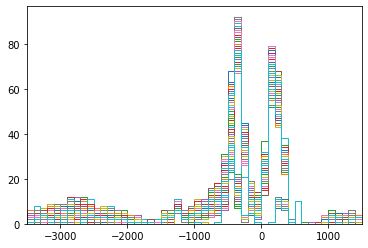

In [ ]:
step = 100
bin_ranges=[n for n in range(-3500, 1500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in length of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-3500, 1500)

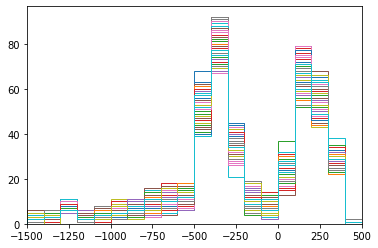

In [ ]:
step = 100
bin_ranges=[n for n in range(-3500, 1500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-1500, 500)

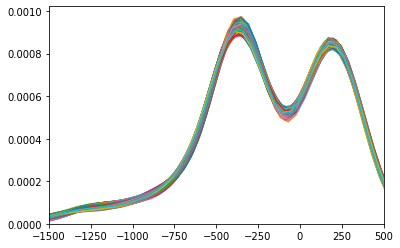

In [ ]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in length of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
  plt.xlim(-1500, 500)

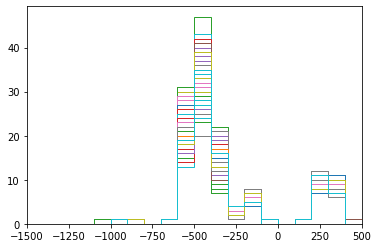

In [ ]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(Izvestia_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = Izvestia_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-1500, 500)

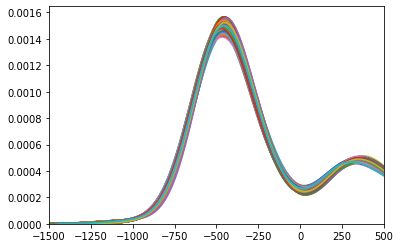

In [ ]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(Izvestia_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = Izvestia_df.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
  plt.xlim(-1500, 500)

## b) Test with PHI

In [ ]:
# read the EDH dataset from sciencedata.dk
PHI = sddk.read_file("SDAM_data/PHI/PHI_dated_2020-06-23.json", "df", conf)

In [ ]:
cd resp.read()

In [ ]:
# in case that the dataset cell values are encasulated within lists (what often happens when the dataset is transformed by R), uncomment the last two lines
def lists_to_values(list_or_value):
  if isinstance(list_or_value, list):
    value = list_or_value[0]
  else: 
    value = list_or_value
  return value
#for column in PHI.columns:
#  PHI[column] = PHI.apply(lambda row: lists_to_values(row[column]), axis=1)

In [ ]:
PHI.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link
1,https://epigraphy.packhum.org/text/1,IG I³,1,None,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None
2,https://epigraphy.packhum.org/text/2,IG I³,2,None,None,Att. — non-stoich. — c. 500 a.,None,14,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None
3,https://epigraphy.packhum.org/text/3,IG I³,3,None,None,Att. — stoich. 21 — 490-480 a.,None,13,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None
4,https://epigraphy.packhum.org/text/4,IG I³,4,None,None,Att. — stoich. 38 — 485/4 a.,None,58,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None
5,https://epigraphy.packhum.org/text/5,IG I³,5,None,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None


In [ ]:
PHI["not_after"] = pd.to_numeric(PHI["not_after"])
PHI["not_before"] = pd.to_numeric(PHI["not_before"])

In [ ]:
len(PHI)

216702

In [ ]:
### how many of the inscriptions have at least one date
PHI_dated = PHI[(PHI["not_before"].notnull()) | (PHI["not_after"].notnull())]
len(PHI_dated)

130946

In [ ]:
%%time
PHI_dated["randoms"] = PHI_dated.apply(lambda row: model_date(row["not_before"], row["not_after"], size=100), axis=1)

CPU times: user 1min 23s, sys: 685 ms, total: 1min 23s
Wall time: 1min 23s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
PHI_dated[(PHI_dated["not_before"] > -10) & (PHI_dated["not_after"] < 10)]

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,randoms
5440,/text/5440?location=1365&patt=&bookid=5&offset...,IG II²,3175,Regions\nAttica (IG I-III)\nAttica,IG II²\n3175,Att. — 10/9-2/3,None,5,1\n\n\n\n5,ὁ δῆμος ἀπὸ τῶν δοθεισῶν δωρεῶν ὑπὸ Γαίου Ἰουλ...,IG-II-2.csv,5440,None,None,10/9-2/3,"{'or': None, 'not_before': 10, 'not_after': 3,...",10.0,3.0,None,[range],None,None,"[12, 14, 13, 13, 16, 13, 15, 16, 12, 12, 15, 1..."
5518,/text/5518?location=1365&patt=&bookid=5&offset...,IG II²,3250,Regions\nAttica (IG I-III)\nAttica,IG II²\n3250,Att. — 2 p.,None,2,1\n,ὁ δῆμος\nΓάιον Καίσαρα Σεβαστοῦ υἱὸν νέον Ἄρη.,IG-II-2.csv,5518,None,None,2 p.,"{'or': None, 'not_before': 2, 'not_after': 2, ...",2.0,2.0,None,[exact],None,None,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
5522,/text/5522?location=1365&patt=&bookid=5&offset...,IG II²,3253,Regions\nAttica (IG I-III)\nAttica,IG II²\n3253,Att. — 4 p.,None,2,1\n,ὁ δῆμος\nΣεβαστὸν Καίσαρα.,IG-II-2.csv,5522,None,None,4 p.,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
5523,/text/5523?location=1365&patt=&bookid=5&offset...,IG II²,3254,Regions\nAttica (IG I-III)\nAttica,IG II²\n3254,Att. — 4 p.,None,2,1\n,ὁ δῆμος\nΤιβέριον Καίσαρα.,IG-II-2.csv,5523,None,None,4 p.,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
5524,/text/5524?location=1365&patt=&bookid=5&offset...,IG II²,3255,Regions\nAttica (IG I-III)\nAttica,IG II²\n3255,Att. — 4 p.,None,2,1\n,ὁ δῆμος\nΓερμανικὸν Καίσαρα.,IG-II-2.csv,5524,None,None,4 p.,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350128,/text/350128?location=1403&patt=&bookid=879&of...,"IG XII,4",2:558,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:558",Kos Isl. — Kos — 9 AD — ClRh 9 (1938) 137-148 ...,Dedication in Nabataean and Greek to Aphrodite...,14,"I.1\n\n\n\n5\nII.6\n\n\n\nI, transl.1\n\n\n\n5",[bjrḥ ․․] šnt 18 lḥr[tt]\n[mlk nbṭ]w | ῾bd ...,IG-XII-4.csv,350128,None,None,9 AD,"{'or': None, 'not_before': 9, 'not_after': 9, ...",9.0,9.0,None,[exact],None,None,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
350209,/text/350209?location=1403&patt=&bookid=879&of...,"IG XII,4",2:637,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:637",Kos Isl. — Halasarna (Kardamaina) — 1-4 AD — R...,Dedication of a shrine to C. Caesar. Base of ...,5,1\n\n\n\n5,ὁ δᾶμος\nὁ Ἁλασαρνιτᾶν\nΓαΐωι Ἰουλίωι θεοῦ Σεβ...,IG-XII-4.csv,350209,None,None,1-4 AD,"{'or': None, 'not_before': 1, 'not_after': 4, ...",1.0,4.0,None,[range],None,None,"[2, 3, 4, 2, 1, 3, 3, 2, 2, 3, 3, 3, 4, 3, 2, ..."
350438,/text/350438?location=1403&patt=&bookid=879&of...,"IG XII,4",2:866,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:866","Kos Isl. — Kos — Asklepieion — 2nd c. BC (I), ...",None,9,I.1\n\nII.1\n\n\n\n\nI.5\n,〚[ὁ δᾶμος] ἐ̣τ̣[ί]μ̣[α]σ̣ε̣〛\n\nΑὖλον Δίδιον Π...,IG-XII-4.csv,350438,None,None,"2nd c. BC (I), late 1st c. BC (II)","{'or': None, 'not_before': -2, 'not_after': -2...",-2.0,-2.0,None,[exact],None,None,"[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -..."
350598,/text/350598?location=1403&patt=&bookid=879&of...,"IG XII,4",2:1024,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:1024","Kos Isl. — Kos — bef. 4 AD — M. Segre, Iscr. d...",Honorific inscription for C. Caesar. Base of ...,4,1\n\n\n,[ἁ βουλ]ὰ Γάϊον\n[Καίσαρ]α Σεβαστοῦ\n[Καίσαρ]ο...,IG-XII-4.csv,350598,None,None,bef. 4 AD,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


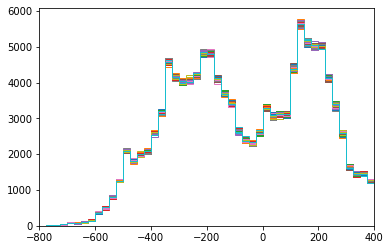

In [ ]:
def get_number(row, n):
  try:
    return row["randoms"][n]
  except:
    return None

step = 25
bin_ranges=[n for n in range(-800, 400 + step, step)]
for n in range(len(PHI_dated.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = PHI_dated.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-800, 400)


(-800.0, 400.0)

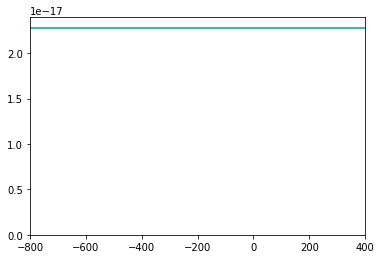

In [ ]:
for n in range(100):
  dates_variant = PHI_dated.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
plt.xlim(-800, 400)

## c) Test with EDH

In [ ]:
# read the EDH dataset from sciencedata.dk
EDH = sddk.read_file("SDAM_data/EDH/EDH_cleaned.json", "df", conf)

In [ ]:
def lists_to_values(list_or_value):
  if isinstance(list_or_value, list):
    value = list_or_value[0]
  else: 
    value = list_or_value
  return value
for column in EDH.columns:
  EDH[column] = EDH.apply(lambda row: lists_to_values(row[column]), axis=1)

In [ ]:
EDH.head(5)

,diplomatic_text,literature,trismegistos_uri,id,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,objecttype,province_label_clean,province_label_certainty,type_of_inscription_clean,type_of_inscription_certainty,material_clean,height_cm,width_cm,depth_cm,type_of_monument_clean,type_of_monument_certainty,findspot_ancient_clean,findspot_ancient_certainty,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence
0,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,HD000001,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"{'cognomen': 'Optata', 'person_id': '1', 'gend...",{},{},{},{},{},{},{},{},{},"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,Tafel,Latium et Campania (Regio I),Certain,epitaph,Certain,Marble,33.0,34.0,2.7,tabula,Certain,Cumae,Estimated,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...
1,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,HD000002,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,{},AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"{'age: years': '70', 'cognomen': 'Paris', 'gen...",1937,"Via Nomentana, S. Alessandro, Kirche",{},{},{},{},{},{},{},"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,Tafel,Roma,Certain,epitaph,Certain,Marble,28.0,85.0,NaN,tabula,Certain,Roma,Certain,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX
2,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,HD000003,{},0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ Ru...",before 1975,{},"Sevilla, Privatbesitz",{},{},{},{},{},{},"37.37281,-6.04589",Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,Statuenbasis,Baetica,Certain,honorific inscription,Certain,Marble,37.0,34.0,12.0,statue base,Certain,NULL,NULL,ummio isenna Xv,Publio Mummio Publi filio Galeria Sisennae Rut...,Publio Mummio Publi filio Galeria Sisennae Rut...
3,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",https://www.trismegistos.org/text/222102,HD000004,Ipolcobulcula,0151,votive inscription,checked with photo,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Spain,Baetica,[---?]AV(?)S(?)[---]L(?)L(?)A / M(arci) Porci ...,limestone: rocks - clastic sediments,(39) cm,27 cm,Carcabuey,18 

In [ ]:
EDH["not_after"] = pd.to_numeric(EDH["not_after"])
EDH["not_before"] = pd.to_numeric(EDH["not_before"])

In [ ]:

### how many of the inscriptions have at least one date
EDH_dated = EDH[(EDH["not_before"].notnull()) | (EDH["not_after"].notnull())]
len(EDH_dated)

57782

In [ ]:
len(EDH_dated[EDH_dated["not_after"].isnull()])

3457

In [ ]:
EDH_dated["randoms"] = EDH_dated.apply(lambda row: model_date(row["not_before"], row["not_after"]), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
EDH_condensed = EDH_dated[["id", "not_before", "not_after", "randoms"]]
EDH_condensed.head(20)

,id,not_before,not_after,randoms
0,HD000001,71.0,130.0,"[118, 113, 126, 113, 99, 99, 90, 91, 89, 124, ..."
1,HD000002,51.0,200.0,"[105, 142, 84, 65, 90, 105, 102, 165, 95, 148,..."
2,HD000003,131.0,170.0,"[157, 136, 135, 132, 151, 160, 145, 133, 146, ..."
3,HD000004,151.0,200.0,"[175, 172, 161, 164, 154, 181, 177, 165, 178, ..."
4,HD000005,1.0,200.0,"[155, 103, 182, 110, 20, 145, 180, 85, 118, 14..."
5,HD000006,71.0,150.0,"[134, 130, 142, 122, 107, 146, 80, 128, 99, 10..."
6,HD000007,-100.0,-51.0,"[-58, -91, -76, -59, -65, -61, -80, -66, -69, ..."
7,HD000008,101.0,200.0,"[154, 123, 117, 114, 162, 144, 165, 109, 161, ..."
8,HD000009,201.0,300.0,"[212, 244, 263, 288, 271, 211, 284, 276, 245, ..."
9,HD000010,101.0,200.0,"[180, 133, 156, 146, 197, 151, 126, 131, 170, ..."


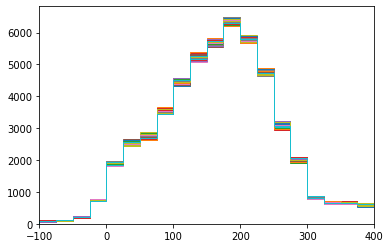

In [ ]:
def get_number(row, n):
  try:
    return row["randoms"][n]
  except:
    return None

step = 25
bin_ranges=[n for n in range(-100, 400 + step, step)]
for n in range(len(EDH_dated.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = EDH_dated.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-100, 400)


(-100.0, 400.0)

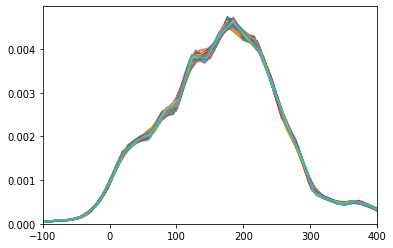

In [ ]:
for n in range(100):
  dates_variant = EDH_condensed.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
plt.xlim(-100, 400)